## Approach
- Used transfer learning by using an imagenet pretrained network
- Since the images are small (28x28), I used resnet18 which is not too deep.
- Converted images to RGB to extract more information
- Used fastai learner for training because:
    1. it has boilerplate code for training a pytorch model
    2. it has onecycle-scheduler which works pretty good in practice and helps in faster convergence.
    3. it has implementation of freezing and unfreezing layers for transfer-learning
- Used concat-pooling after the conv-layers which works better than the usual Flatten layer
- Resized images to 224x224 during preprocessing using bilinear interpolation to get a better receptive-field as compared to 28x28.
- Fine-tuning pretrained conv-layers didn't help

## Load libraries

In [1]:
import pandas as pd
from PIL import Image
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Libraries specific to deep learning
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from fastai.vision import DataBunch, Learner
from torchvision import models, transforms

**Seed for reproducibility**

In [2]:
SEED = 7

# python RNG
random.seed(SEED)

# pytorch RNGs
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# numpy RNG
np.random.seed(SEED)

In [3]:
# View the available files
PATH = Path('../input/vision_task_dataset_public-20190406t113732z-001/Vision_task_dataset_public')
[f.name for f in PATH.iterdir()]

['train_image.pkl',
 'test_image.pkl',
 'hitkul(sample_submission).csv',
 'train_label.pkl']

## Load data

In [4]:
with open(PATH/'train_image.pkl', 'rb') as f:
    train_imgs = pickle.load(f)

with open(PATH/'test_image.pkl', 'rb') as f:
    test_imgs = pickle.load(f)

with open(PATH/'train_label.pkl', 'rb') as f:
    train_lbls = pickle.load(f)

samples_df = pd.read_csv(PATH/'hitkul(sample_submission).csv')
print(f'Sample Size: {samples_df.shape}')
samples_df.head()

Sample Size: (4, 2)


,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


In [5]:
# Amount of samples available for each class
pd.Series(train_lbls).value_counts(normalize=True)

3    0.25
6    0.25
2    0.25
0    0.25
dtype: float64

Looks like we have a perfectly balanced dataset

## Visualize the data

In [6]:
def show_grid(imgs, lbls, mat=3, figsize=(8, 8)):
    "Takes the images and labels and display them in a grid"
    ixs = random.sample(range(len(imgs)), mat**2)

    _, axes = plt.subplots(mat, mat, figsize=figsize)
    for i, ix in enumerate(ixs):
        ax = axes[i // mat, i % mat]
        ax.imshow(np.array(imgs[i]).reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(lbls[ix])

**Let's see the images along with their labels
**

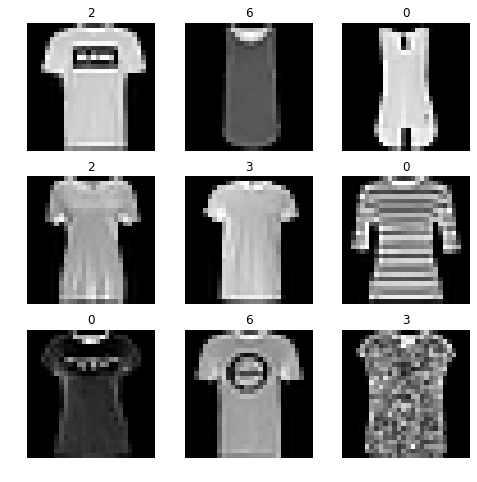

In [7]:
show_grid(train_imgs, train_lbls)

## Pytorch Module layers

In [8]:
class Flatten(nn.Module):
    "Flattens the input tensor to 2D tensor"
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats AdaptiveAvgPool2d and AdaptiveMaxPool2d"
    def __init__(self):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)

    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)

## Create network

In [9]:
def bn_lin_layer(f_in, f_out, ps):
    "Sequence of Batchnorm, Dropout, Linear and ReLU activation layer"
    return [nn.BatchNorm1d(f_in), nn.Dropout(ps), nn.Linear(f_in, f_out), nn.ReLU(inplace=True)]

def create_body(arch, pretrained):
    "Creates the body by removing the linear-layers from a pretrained model"
    return nn.Sequential(*list(arch(pretrained=pretrained).children())[:-2])


def create_head(n_feats, n_classes, lin_layers, concat_pool, ps):
    "Create the head of the model with linear layers and AdaptiveConcatPool2d"
    lin_layers = [n_feats] + lin_layers + [n_classes]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]

    for f_in, f_out in zip(lin_layers[:-1], lin_layers[1:]):
        layers.extend(bn_lin_layer(f_in, f_out, ps))

    return nn.Sequential(*layers[:-1])


def create_net(arch, lin_layers, n_classes, pretrained=False, concat_pool=False, ps=0.5):
    "Creates the architecture by joining the body and head in sequence"
    pre_body = create_body(arch, pretrained)
    n_feats = 512 * (2 if concat_pool else 1)
    pre_head = create_head(n_feats, n_classes, lin_layers, concat_pool, ps)

    return nn.Sequential(pre_body, pre_head)

## Datasets and Dataloaders

In [10]:
class VisionDataset(Dataset):
    """
    Dataset class inhereted from pytorch Dataset which preprocess the arrays
    and apply augmentation of the tensors
    """
    def __init__(self, data, tfms, labels=None):
        """
        Arguments
            data: array with each element defining the 1d-tensor pixels
            tfms: defines the transforms for augmentation
            labels: defines the actual labels
        """
        self.data = data
        self.tfms = tfms
        self.labels = labels

    def __getitem__(self, idx):
        "Returns one item at a time depending upon the index: idx"
        # Convert tensor to PIL.Image and then to RGB
        item = Image.fromarray(np.array(self.data[idx]).reshape(28, 28).astype(np.uint8))
        item = item.convert('RGB')
        
        # Apply transforms
        item = self.tfms(item)
        
        if self.labels is None:
            return item
        return item, self.labels[idx]

    def __len__(self):
        "Returns the length of the dataset"
        return len(self.data)

In [11]:
def get_dls(train_imgs, train_lbls, test_imgs, tfms, batch_sz, n_workers, valid_split=0.2):
    "Creates the dataloaders for training, validation and testing"
    
    # Shuffle the data since the original labels are in sequence
    d_size = len(train_imgs)
    ixs = np.random.permutation(range(d_size))
    
    # Split into train and valid
    split = int(d_size * valid_split)
    train_ixs, valid_ixs = ixs[split:], ixs[:split]

    # Sampler for train and valid dataset
    train_sampler = SubsetRandomSampler(train_ixs)
    valid_sampler = SubsetRandomSampler(valid_ixs)

    # Create the train and test dataset
    train_ds = VisionDataset(train_imgs, tfms[0], train_lbls)
    test_ds = VisionDataset(test_imgs, tfms[1])

    # Create the dataloaders
    train_dl = DataLoader(train_ds, batch_sz, sampler=train_sampler, num_workers=n_workers)
    valid_dl = DataLoader(train_ds, batch_sz, sampler=valid_sampler, num_workers=n_workers)
    test_dl = DataLoader(test_ds, batch_sz, num_workers=n_workers)

    return train_dl, valid_dl, test_dl

## Metrics

In [12]:
def accuracy(preds, targets):
    preds = torch.max(preds, dim=1)[1]
    return (preds == targets).float().mean()

## Workflow

In [13]:
# Some constants
BATCH_SIZE = 64
NUM_WORKERS = 4
SIZE = 224

# Device on which our model will run
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Map the labels to classes 
lb2cl = {v: k for k, v in enumerate(pd.Series(train_lbls).unique())}
cl2lb = {v: k for k, v in lb2cl.items()}

# Map the actual labels to classes which will be used to calucate the loss
train_targets = [lb2cl[lb] for lb in train_lbls]

### Preprocessing Transforms

In [14]:
# Since we are using pretrained-imagenet model we better use imagenet stats
stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

# Transforms to be applied during preprocessing
train_tfms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(stats[0], stats[1])
])

test_tfms = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(stats[0], stats[1])
])

tfms = [train_tfms, test_tfms]

### Create databunch and model

In [15]:
# Get the dataloaders
train_dl, valid_dl, test_dl = get_dls(train_imgs, train_targets, test_imgs, tfms, BATCH_SIZE, NUM_WORKERS)

# Create fastai DataBunch
data_bunch = DataBunch(train_dl, valid_dl)

# Create the model using resnet18 architecture
model = create_net(models.resnet18, [512, 256], 4, pretrained=True, concat_pool=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
46827520it [00:02, 22636662.05it/s]


### Fastai Learner

In [16]:
# Create learner which will contain the data, model, optimizer, loss function and metrics
learn = Learner(data_bunch, model, opt_func=optim.Adam, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])

# Create layer groups of the network for fine-tuning
learn = learn.split([learn.model[0][6], learn.model[1]])

# Freeze all the layer-groups except the last one
learn.freeze()

### Training

In [17]:
# Train the network with 4 epochs using fastai OneCycleScheduler
learn.fit_one_cycle(3, max_lr=8e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.610250,0.431765,0.833750,00:20
1,0.468174,0.307978,0.883750,00:19
2,0.344872,0.271091,0.896875,00:19


Save the weights


In [18]:
learn.save('stage-1')

## Testing

In [19]:
test_preds = []

# Make predictions batch-wise
for a in tqdm(test_dl):
    test_preds.extend(torch.argmax(learn.model(a.cuda()), dim=1).cpu().numpy().tolist())

100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


## Save the test predictions

In [20]:
# Re-map to original labels
test_preds = [cl2lb[p] for p in test_preds]

# Create and save the dataframe
test_sub = pd.DataFrame({'image_index': range(len(test_preds)), 'class': test_preds})
test_sub.to_csv('Rohit_Gupta.csv', header=True, index=False)
print(f'Test size: {test_sub.shape}')
test_sub.head()

Test size: (2000, 2)


,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
